# WASP-39b NIRSpec ExoIris analysis

**Author:** Hannu Parviainen </br>
**Edited:** 2025-08-08 </br>
**ExoIris version:** 0.19 

This notebook carries out an ExoIris transmission spectroscopy analysis for the JWST NIRSpec observations of WASP-39b reduced by [Carter et al. (2024)](https://www.nature.com/articles/s41550-024-02292-x). The original reduction and analysis of the observations were presented in [Alderson et al. (2023)](https://www.nature.com/articles/s41586-022-05591-3).

**Note:** This notebook assumes you have already read the basic [ExoIris tutorials](https://exoiris.readthedocs.io/en/latest/examples/index.html).

In [1]:
%run ../setup_multiprocessing.py

In [2]:
from multiprocessing import Pool

import numpy as np
import xarray as xa

from matplotlib.pyplot import subplots, setp, rc
from exoiris import ExoIris, TSData

rc('figure', figsize=(14, 4))

In [3]:
%run read_data.py
%run core.py

## Read the data

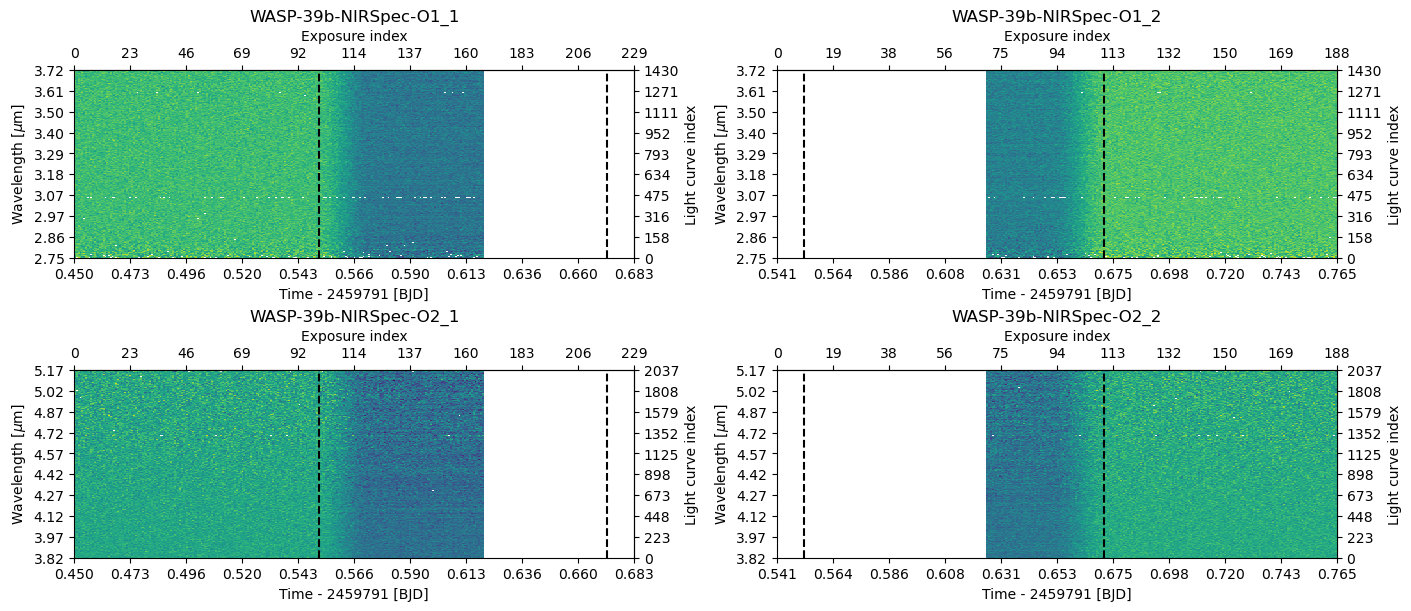

In [4]:
d1 = read_data('data/ZENODO/1_TIME_SERIES_SPECTRA/NIRSpec_G395H_NRS1_Spectra.h5', 'WASP-39b-NIRSpec-O1', ephemeris=eph, ngroup=0)
d1.normalize_to_poly()
d1.crop_wavelength(2.75, np.inf)
d1.mask_outliers()
d1a, d1b = d1.partition_time(((2459791.45, 2459791.62), (2459791.625, np.inf)))
d1a.normalize_to_poly()
d1b.normalize_to_poly()

d2 = read_data('data/ZENODO/1_TIME_SERIES_SPECTRA/NIRSpec_G395H_NRS2_Spectra.h5', 'WASP-39b-NIRSpec-O2', ephemeris=eph, ngroup=1)
d2.normalize_to_poly()
d2.mask_outliers()
d2a, d2b = d2.partition_time(((2459791.45, 2459791.62), (2459791.625, np.inf)))
d2a.normalize_to_poly()
d2b.normalize_to_poly()

fig, axs = subplots(2, 2, figsize=(14, 6), constrained_layout=True)
d1a.plot(ax=axs[0, 0])
d1b.plot(ax=axs[0, 1])
d2a.plot(ax=axs[1, 0])
d2b.plot(ax=axs[1, 1]);

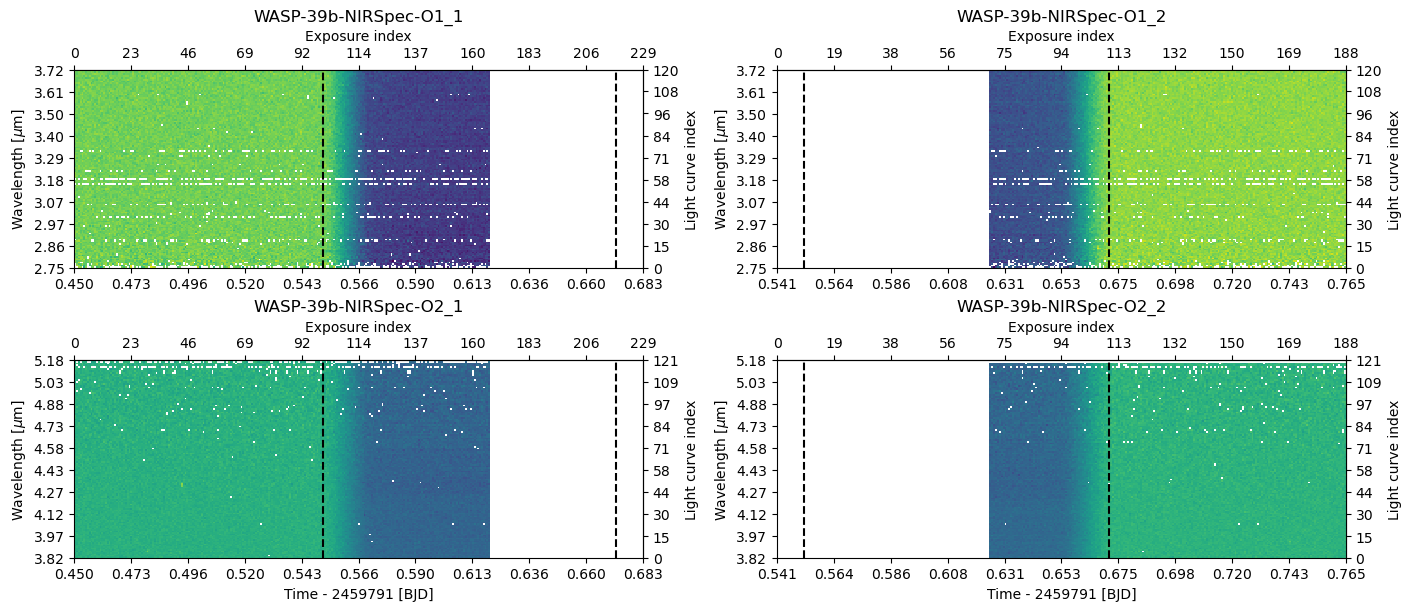

In [5]:
db = (d1a.bin_wavelength(r=400, estimate_errors=False) + 
      d1b.bin_wavelength(r=400, estimate_errors=False) + 
      d2a.bin_wavelength(r=400, estimate_errors=False) + 
      d2b.bin_wavelength(r=400, estimate_errors=False))

fig, axs = subplots(2, 2, figsize=(14, 6), constrained_layout=True)
db.plot(axs);

Estimate the average uncertainties for each spectrophotometric light curve based on the out-of-transit data.

In [6]:
[d.estimate_average_uncertainties() for d in db];

## Initialise the analysis

In [7]:
ts = ExoIris('WASP-39b-NIRSpec-wn', 'power-2', db, nk=100, interpolation='makima')

In [8]:
ts.set_prior('tc_00', 'NP', eph.transit_center(db[0].time.mean()), 0.003)  # Zero epoch for epoch group 0
ts.set_prior('p', 'NP', eph.period, 1e-5)                                  # Orbital period
ts.set_prior('sigma_m_00', 'UP', 0.8, 2.0)                                 # Uncertainty multiplier for noise group 0
ts.set_prior('sigma_m_01', 'UP', 0.8, 2.0)                                 # Uncertainty multiplier for noise group 1
ts.set_prior('bl_00_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 0
ts.set_prior('bl_01_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 1
ts.set_prior('bl_02_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 0
ts.set_prior('bl_03_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 1
ts.set_radius_ratio_prior('UP', 0.14, 0.155)                             
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

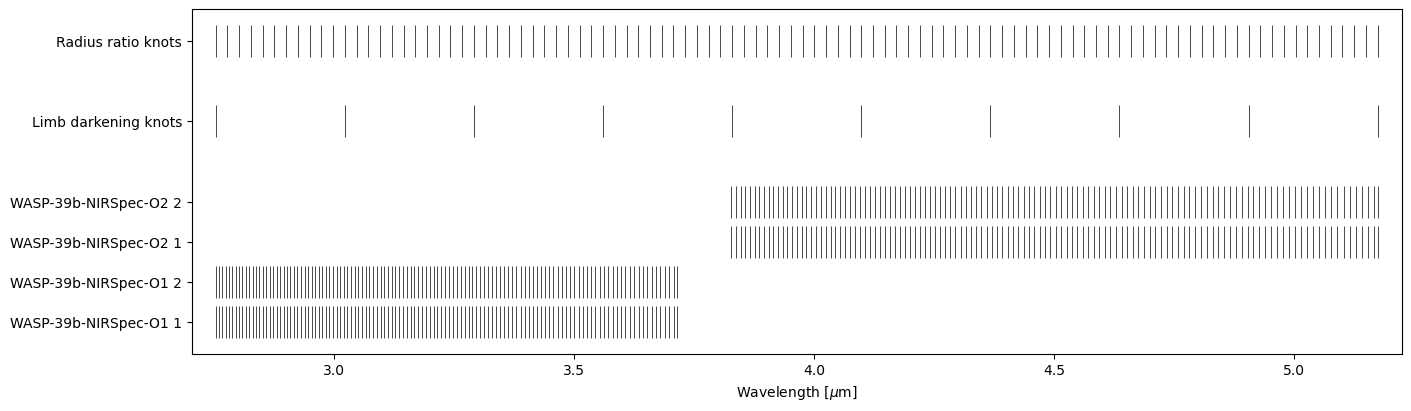

In [9]:
ts.plot_setup();

## Fit the white light curve

In [10]:
ts.fit_white()

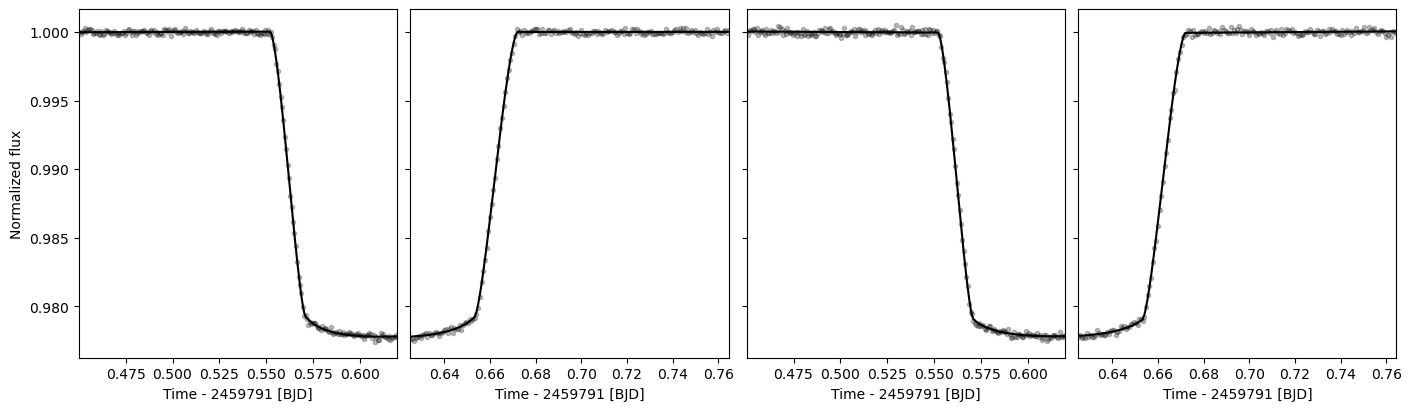

In [11]:
ts.plot_white(ncols=4, figsize=(14, 4));

In [12]:
ts.save(overwrite=True)

## Fit the transmission spectroscopy

In [13]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

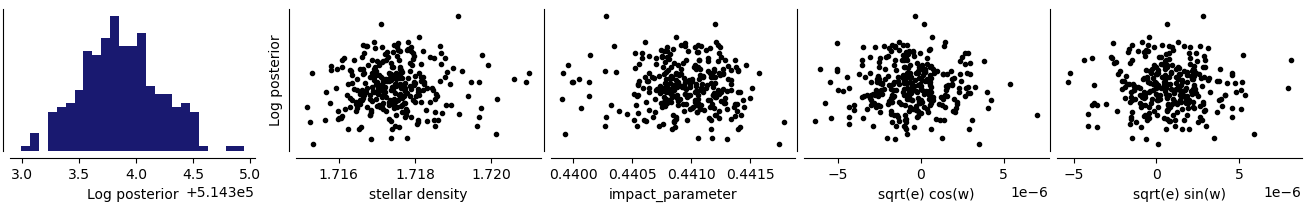

In [14]:
ts.fit(niter=2500, npop=300, pool=pool, lnpost=lnpostf)

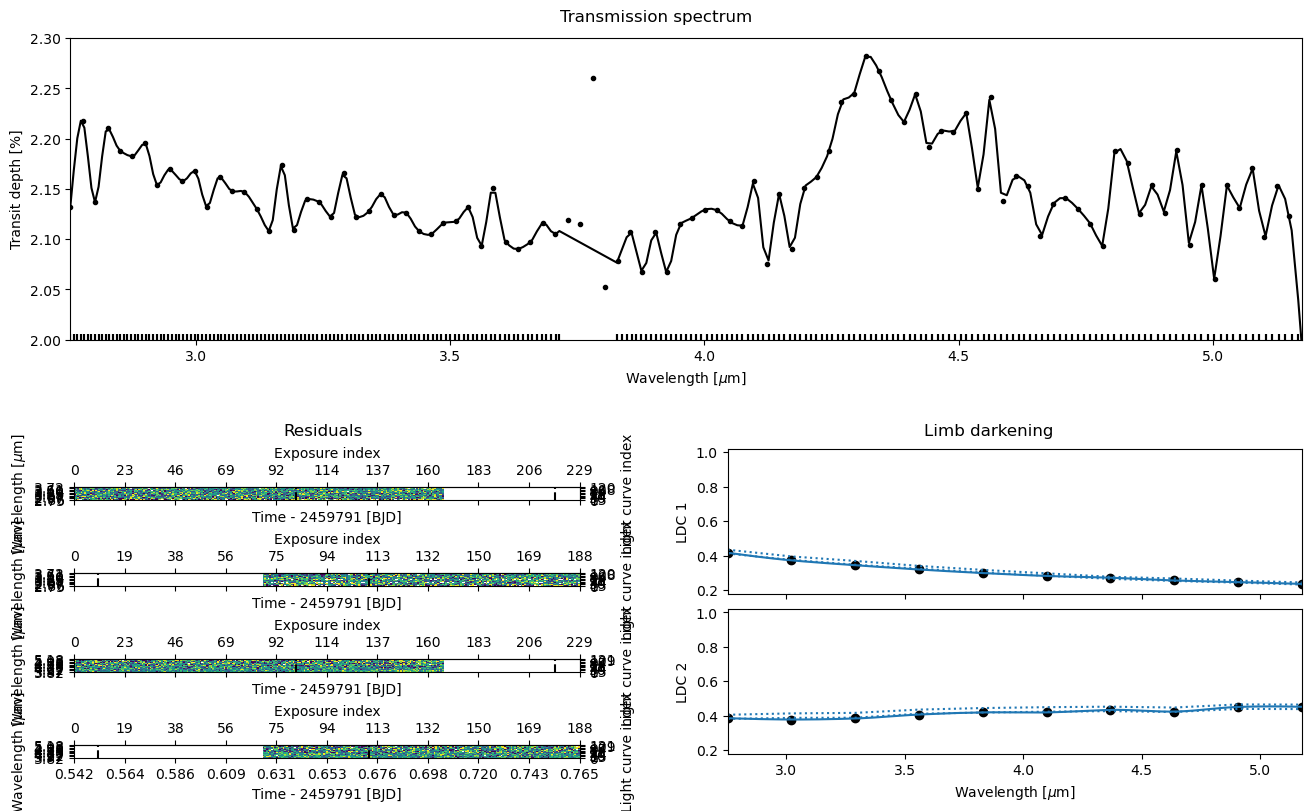

In [15]:
ts.plot_fit(result='fit', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.3)));

In [16]:
ts.save(overwrite=True)

## Sample the posterior

In [ ]:
ts.sample(1000, thin=100, repeats=6, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 4/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 5/6:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ts.plot_fit(result='mcmc', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.3)));

In [ ]:
ts.save()

In [ ]:
pool.close()

---

<center>&copy;2025 Hannu Parviainen</center>